## Framework for Adversarial Spoofing and Evasion of Rule-based ICS-NIDS (FASER-IN)

Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import re

from C45 import C45Classifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from itertools import product
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from scapy.all import rdpcap, wrpcap, Ether, IP, TCP

In [2]:
import time

start_time = time.time()

In [3]:
SEED = 42
np.random.seed(SEED)

Load Dataset

In [4]:
### Obtain relevant features in csv format from pcap using features.py -- change the ground truth ranges in the features.py as per your dataset.
### Append 'Predictions' in the file obtained (features_10.csv) from features.py. Split the file into training and evaluation and upload below.

train = pd.read_csv('dataset_train.csv')
test = pd.read_csv('dataset_eval.csv')

One-hot Encoding

In [5]:
combined = pd.concat([train, test], keys=['train', 'test'], ignore_index=False)

X_combined = combined.drop(['Predictions', 'ground_truth', 'frame.number'], axis=1).fillna(0).astype(str)

X_combined_encoded = pd.get_dummies(X_combined, drop_first=True).fillna(0)

train_rows = combined.index.get_level_values(0) == 'train'
X_train_encoded = X_combined_encoded[train_rows]
X_test_encoded = X_combined_encoded[~train_rows]

y_pred_eval_clean = test['Predictions_2'].astype(int)  ### Predictions corresponding to notifications by only sending eval.pcap to the NIDS.

y_train = train['Predictions'].astype(str)
y_train_gt = train['ground_truth'].astype(str)
y_test = test['Predictions'].astype(str)
y_test_gt = test['ground_truth'].astype(str)

X_train = train.drop(['Predictions', 'ground_truth', 'frame.number'], axis=1).fillna(0).astype(str)
X_test = test.drop(['Predictions', 'ground_truth', 'frame.number', 'Predictions_2'], axis=1).fillna(0).astype(str)



Performance Measure of NIDS

Performance Measure of NIDS
Accuracy: 0.8973
Precision: 0.6176
Recall: 0.9130


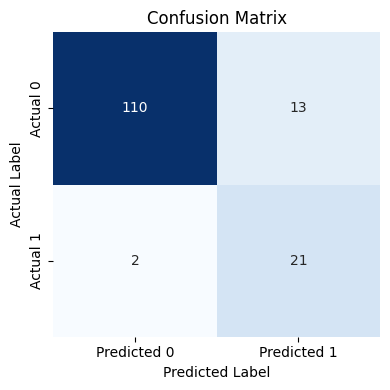

In [6]:
y_gt_test = list(map(int, y_test_gt))

# Calculate accuracy, precision, and recall for Ground Truth
nids_clean_accuracy = accuracy_score(y_gt_test, y_pred_eval_clean)
nids_clean_precision = precision_score(y_gt_test, y_pred_eval_clean)
nids_clean_recall = recall_score(y_gt_test, y_pred_eval_clean)
nids_clean_conf_matrix = confusion_matrix(y_gt_test, y_pred_eval_clean)

print("Performance Measure of NIDS")
print(f"Accuracy: {nids_clean_accuracy:.4f}")
print(f"Precision: {nids_clean_precision:.4f}")
print(f"Recall: {nids_clean_recall:.4f}")

plt.figure(figsize=(4, 4))

sns.heatmap(nids_clean_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('clean_performance_nids_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


Surrogate Models

Random Search to get various parameters for the decision tree

In [67]:
### Run these 2 cells if you need to update the parameters for the decision trees.

# model = DecisionTreeClassifier()

# param_dist = {
#     'max_depth': randint(3, 20),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random']
# }

# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
# random_search.fit(X_train_encoded, y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best cross-validation score:", random_search.best_score_)

In [68]:
# y_test_random = test['Predictions'].astype(str)
# best_model = DecisionTreeClassifier(**random_search.best_params_)
# best_model.fit(X_train_encoded, y_train)

# print("Test accuracy:", best_model.score(X_test_encoded, y_test_random))

Model 1 - Classification And Regression Tree (CART)

In [7]:
model_1 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=SEED)  
model_1.fit(X_train_encoded, y_train)

DecisionTreeClassifier(random_state=42)

In [8]:
plt.figure(figsize=(15, 10), dpi=800)  
plot_tree(model_1, filled=True, feature_names=X_train_encoded.columns, class_names=['0', '1'])
plt.title("Model 1 - Decision Tree")
plt.savefig('model_1_decision_tree.pdf', format='pdf', dpi=800)
plt.show()

In [9]:
y1_pred = model_1.predict(X_test_encoded)

Similarity to NIDS Predictions
Accuracy (Fidelity): 0.9178
Precision: 0.7895
Recall: 0.8824

Clean Metrics wrt Ground Truth
Accuracy: 0.8562
Precision: 0.5263
Recall: 0.8696


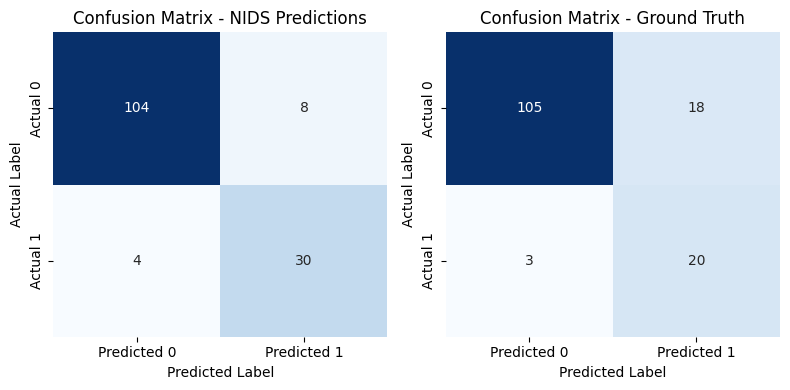

In [10]:
y_test = list(map(int, y_test))
y1_pred = list(map(int, y1_pred))
y_gt_test = list(map(int, y_test_gt))

# Calculate accuracy, precision, and recall w.r.t NIDS prediction
accuracy_1 = accuracy_score(y_test, y1_pred)
precision_1 = precision_score(y_test, y1_pred)
recall_1 = recall_score(y_test, y1_pred)
conf_matrix_1 = confusion_matrix(y_test, y1_pred)

# Calculate accuracy, precision, and recall w.r.t Ground Truth
accuracy_gt_1 = accuracy_score(y_gt_test, y1_pred)
precision_gt_1 = precision_score(y_gt_test, y1_pred)
recall_gt_1 = recall_score(y_gt_test, y1_pred)
conf_matrix_gt_1 = confusion_matrix(y_gt_test, y1_pred)

print("Similarity to NIDS Predictions")
print(f"Accuracy (Fidelity): {accuracy_1:.4f}")
print(f"Precision: {precision_1:.4f}")
print(f"Recall: {recall_1:.4f}\n")

print("Clean Metrics wrt Ground Truth")
print(f"Accuracy: {accuracy_gt_1:.4f}")
print(f"Precision: {precision_gt_1:.4f}")
print(f"Recall: {recall_gt_1:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix - NIDS Predictions')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_gt_1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Ground Truth')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_1_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


Model 2 - C4.5

In [11]:
model_2 = C45Classifier()
model_2.fit(X_train, y_train)

model_2.summary()

Decision Tree Classifier Summary
Number of Instances   :  839
Number of Attributes  :  29
Number of Leaves      :  90
Number of Rules       :  90
Tree Depth            :  4


In [12]:
model_2.generate_tree_diagram(graphviz,"model_2_decision_tree")

'model_2_decision_tree.png'

In [13]:
model_2.print_rules()

function = ACYCLIC IO ALARM LOW AND eth.dst = 54:e3:b0:00:55:b1 A => 1
function = ACYCLIC IO ALARM LOW AND eth.dst = 54:e3:b0:00:55:b7 A => 1
function = ACYCLIC IO ALARM LOW AND eth.dst = ac:64:17:03:4f:c5 AND eth.src = 54:e3:b0:00:55:b7 A => 1
function = ACYCLIC IO ALARM LOW AND eth.dst = ac:64:17:03:4f:c5 AND eth.src = 28:63:36:9a:90:b3 A => 0
function = ACYCLIC IO ALARM LOW AND eth.dst = 28:63:36:9a:90:b3 A => 0
function = PN DCP SET REQUEST A => 1
function = PN DCP IDENTIFY RESPONSE SUCCESS A => 0
function = DCE RPC CONTROL RESPONSE AND eth.src = 28:63:36:a9:ac:eb A => 0
function = DCE RPC CONTROL RESPONSE AND eth.src = 54:e3:b0:00:55:b7 A => 1
function = DCE RPC CONTROL RESPONSE AND eth.src = ac:64:17:03:4f:c5 AND eth.dst = 54:e3:b0:00:55:b7 A => 1
function = DCE RPC CONTROL RESPONSE AND eth.src = ac:64:17:03:4f:c5 AND eth.dst = 00:60:34:12:ab:7f A => 0
function = DCE RPC CONTROL RESPONSE AND eth.src = 54:e3:b0:00:55:b1 A => 0
function = DCE RPC CONTROL RESPONSE AND eth.src = 28:6

In [14]:
y2_pred = model_2.predict(X_test)

Similarity to NIDS Predictions
Accuracy (Fidelity): 0.7740
Precision: 0.5075
Recall: 1.0000

Clean Metrics wrt Ground Truth
Accuracy: 0.6712
Precision: 0.3134
Recall: 0.9130


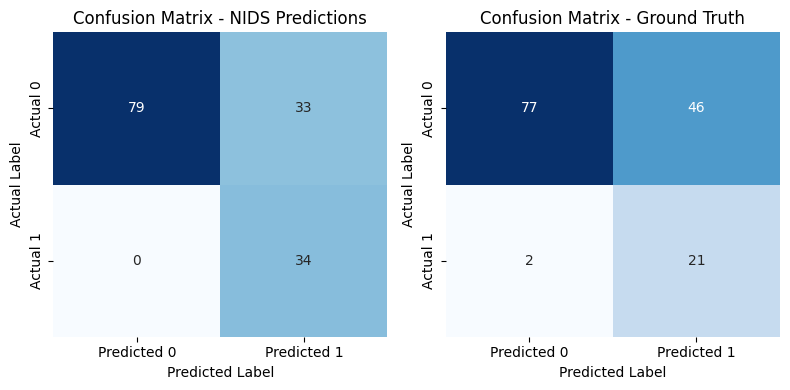

In [15]:
y_test = list(map(int, y_test))
y2_pred = list(map(int, y2_pred))
y_gt_test = list(map(int, y_test_gt))

# Calculate accuracy, precision, and recall for NIDS prediction
accuracy_2 = accuracy_score(y_test, y2_pred)
precision_2 = precision_score(y_test, y2_pred)
recall_2 = recall_score(y_test, y2_pred)
conf_matrix_2 = confusion_matrix(y_test, y2_pred)

# Calculate accuracy, precision, and recall for Ground Truth
accuracy_gt_2 = accuracy_score(y_gt_test, y2_pred)
precision_gt_2 = precision_score(y_gt_test, y2_pred)
recall_gt_2 = recall_score(y_gt_test, y2_pred)
conf_matrix_gt_2 = confusion_matrix(y_gt_test, y2_pred)

print("Similarity to NIDS Predictions")
print(f"Accuracy (Fidelity): {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}\n")

print("Clean Metrics wrt Ground Truth")
print(f"Accuracy: {accuracy_gt_2:.4f}")
print(f"Precision: {precision_gt_2:.4f}")
print(f"Recall: {recall_gt_2:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix - NIDS Predictions')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_gt_2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Ground Truth')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_2_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


Model 3 - CART

In [16]:
model_3 = DecisionTreeClassifier(criterion= 'gini', max_depth= 16, min_samples_leaf= 2, min_samples_split= 5, splitter= 'best', random_state=SEED)  
model_3.fit(X_train_encoded, y_train)

DecisionTreeClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [17]:
plt.figure(figsize=(15, 10), dpi=800)  
plot_tree(model_3, filled=True, feature_names=X_train_encoded.columns, class_names=['0', '1'])
plt.title("Model 3 - Decision Tree")
plt.savefig('model_3_decision_tree.pdf', format='pdf', dpi=800)
plt.show()



In [18]:
y3_pred = model_3.predict(X_test_encoded)

Similarity to NIDS Predictions
Accuracy (Fidelity): 0.9178
Precision: 0.7895
Recall: 0.8824

Clean Metrics wrt Ground Truth
Accuracy: 0.8562
Precision: 0.5263
Recall: 0.8696


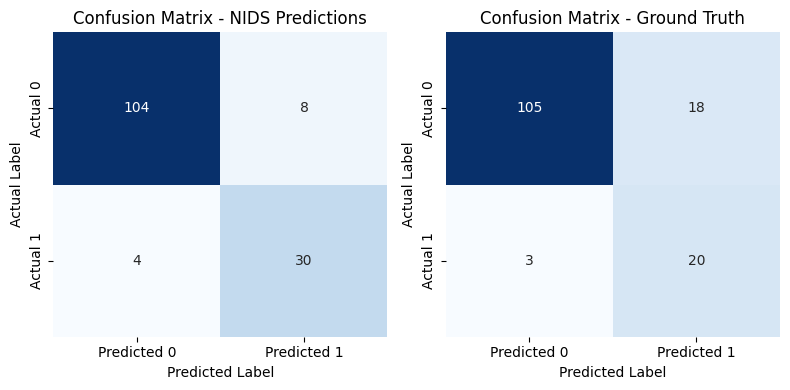

In [19]:
y_test = list(map(int, y_test))
y3_pred = list(map(int, y3_pred))
y_gt_test = list(map(int, y_test_gt))

# Calculate accuracy, precision, and recall for NIDS prediction
accuracy_3 = accuracy_score(y_test, y3_pred)
precision_3 = precision_score(y_test, y3_pred)
recall_3 = recall_score(y_test, y3_pred)
conf_matrix_3 = confusion_matrix(y_test, y3_pred)

# Calculate accuracy, precision, and recall for Ground Truth
accuracy_gt_3 = accuracy_score(y_gt_test, y3_pred)
precision_gt_3 = precision_score(y_gt_test, y3_pred)
recall_gt_3 = recall_score(y_gt_test, y3_pred)
conf_matrix_gt_3 = confusion_matrix(y_gt_test, y3_pred)

print("Similarity to NIDS Predictions")
print(f"Accuracy (Fidelity): {accuracy_3:.4f}")
print(f"Precision: {precision_3:.4f}")
print(f"Recall: {recall_3:.4f}\n")

print("Clean Metrics wrt Ground Truth")
print(f"Accuracy: {accuracy_gt_3:.4f}")
print(f"Precision: {precision_gt_3:.4f}")
print(f"Recall: {recall_gt_3:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix - NIDS Predictions')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_gt_3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Ground Truth')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_3_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


Model 4 - CART

In [20]:
model_4 = DecisionTreeClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 1, min_samples_split= 5, splitter= 'random', random_state=SEED)  
model_4.fit(X_train_encoded, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42, splitter='random')

In [21]:
plt.figure(figsize=(15, 10), dpi=800) 
plot_tree(model_4, filled=True, feature_names=X_train_encoded.columns, class_names=['0', '1']) 
plt.title("Model 4 - Decision Tree")
plt.savefig('model_4_decision_tree.pdf', format='pdf', dpi=800)
plt.show()


In [22]:
y4_pred = model_4.predict(X_test_encoded)

Similarity to NIDS Predictions
Accuracy (Fidelity): 0.9315
Precision: 0.8333
Recall: 0.8824

Clean Metrics wrt Ground Truth
Accuracy: 0.8699
Precision: 0.5556
Recall: 0.8696


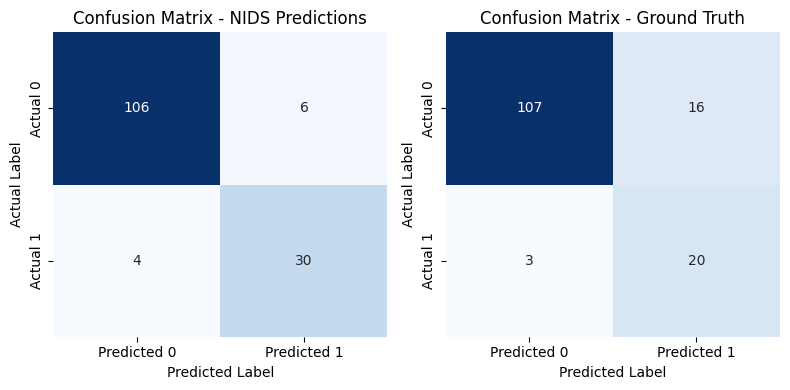

In [23]:
y_test = list(map(int, y_test))
y4_pred = list(map(int, y4_pred))
y_gt_test = list(map(int, y_test_gt))

# Calculate accuracy, precision, and recall for NIDS prediction
accuracy_4 = accuracy_score(y_test, y4_pred)
precision_4 = precision_score(y_test, y4_pred)
recall_4 = recall_score(y_test, y4_pred)
conf_matrix_4 = confusion_matrix(y_test, y4_pred)

# Calculate accuracy, precision, and recall for Ground Truth
accuracy_gt_4 = accuracy_score(y_gt_test, y4_pred)
precision_gt_4 = precision_score(y_gt_test, y4_pred)
recall_gt_4 = recall_score(y_gt_test, y4_pred)
conf_matrix_gt_4 = confusion_matrix(y_gt_test, y4_pred)

print("Similarity to NIDS Predictions")
print(f"Accuracy (Fidelity): {accuracy_4:.4f}")
print(f"Precision: {precision_4:.4f}")
print(f"Recall: {recall_4:.4f}\n")

print("Clean Metrics wrt Ground Truth")
print(f"Accuracy: {accuracy_gt_4:.4f}")
print(f"Precision: {precision_gt_4:.4f}")
print(f"Recall: {recall_gt_4:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(conf_matrix_4, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix - NIDS Predictions')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_gt_4, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Ground Truth')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_4_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


Model 5 - CART

In [25]:
model_5 = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, min_samples_leaf= 1, min_samples_split= 10, splitter= 'random', random_state=SEED)  
model_5.fit(X_train_encoded, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42,
                       splitter='random')

In [26]:
plt.figure(figsize=(15, 10), dpi=800)  
plot_tree(model_5, filled=True, feature_names=X_train_encoded.columns, class_names=['0', '1'])
plt.title("Model 5 - Decision Tree")
plt.savefig('model_5_decision_tree.pdf', format='pdf', dpi=800)
plt.show()


In [27]:
y5_pred = model_5.predict(X_test_encoded)

Similarity to NIDS Predictions
Accuracy (Fidelity): 0.9247
Precision: 0.8286
Recall: 0.8529

Clean Metrics wrt Ground Truth
Accuracy: 0.8630
Precision: 0.5429
Recall: 0.8261


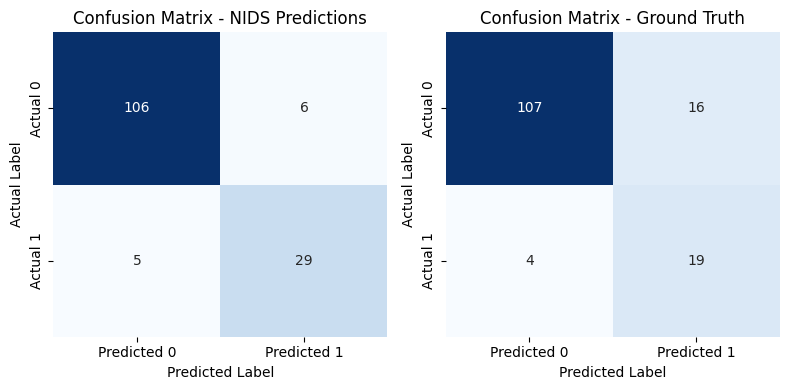

In [28]:
y_test = list(map(int, y_test))
y5_pred = list(map(int, y5_pred))
y_gt_test = list(map(int, y_test_gt))

# Calculate accuracy, precision, and recall for NIDS prediction
accuracy_5 = accuracy_score(y_test, y5_pred)
precision_5 = precision_score(y_test, y5_pred)
recall_5 = recall_score(y_test, y5_pred)
conf_matrix_5 = confusion_matrix(y_test, y5_pred)

# Calculate accuracy, precision, and recall for Ground Truth
accuracy_gt_5 = accuracy_score(y_gt_test, y5_pred)
precision_gt_5 = precision_score(y_gt_test, y5_pred)
recall_gt_5 = recall_score(y_gt_test, y5_pred)
conf_matrix_gt_5 = confusion_matrix(y_gt_test, y5_pred)

print("Similarity to NIDS Predictions")
print(f"Accuracy (Fidelity): {accuracy_5:.4f}")
print(f"Precision: {precision_5:.4f}")
print(f"Recall: {recall_5:.4f}\n")

print("Clean Metrics wrt Ground Truth")
print(f"Accuracy: {accuracy_gt_5:.4f}")
print(f"Precision: {precision_gt_5:.4f}")
print(f"Recall: {recall_gt_5:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(conf_matrix_5, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Confusion Matrix - NIDS Predictions')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_gt_5, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Ground Truth')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_5_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


Choose a Surroagte Model based on best Fidelity or Accuracy w.r.t NIDS predictions

In [29]:
# Accuracy scores (Fidelity) for surrogate models
accuracy_scores = {
    "Model_1": accuracy_1,
    "Model_2": accuracy_2,
    "Model_3": accuracy_3,
    "Model_4": accuracy_4,
    "Model_5": accuracy_5
}

models = {
    "Model_1": model_1,
    "Model_2": model_2,
    "Model_3": model_3,
    "Model_4": model_4,
    "Model_5": model_5
}

# Find the maximum accuracy (Fidelity)
max_accuracy = max(accuracy_scores.values())

# Get all models with the maximum accuracy (to handle ties)
best_models = [model for model, acc in accuracy_scores.items() if acc == max_accuracy]

# If there's a tie, select a random model
if len(best_models) > 1:
    selected_model_name = random.choice(best_models)
    print(f"Tie detected between models: {best_models}")
else:
    selected_model_name = best_models[0]

# Get the corresponding model object
selected_model = models[selected_model_name]

print(f"The selected model is {selected_model_name} with an accuracy of {max_accuracy:.2f}")

The selected model is Model_4 with an accuracy of 0.93


In [30]:
### Save the model
filename = f"{selected_model_name}.pkl"
with open(filename, "wb") as file:
    pickle.dump(selected_model, file)
    print(f"The model has been saved as {filename}")

The model has been saved as Model_4.pkl


AutoSpoofing 

In [31]:
df1 = train

columns_to_analyze = ['eth.src', 'ip.src', 'tcp.checksum', 'udp.checksum']

counts = {}
for col in columns_to_analyze:
    counts[col.split('.')[0]] = (df1[col] != '0').sum()  

protocol_counts = df1['protocol'].value_counts()
for protocol, count in protocol_counts.items():
    if protocol != '0':  
        counts[protocol] = count

counts_df = pd.DataFrame(list(counts.items()), columns=['Column', 'Count'])

counts_df = counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

print(counts_df)


     Column  Count
0       eth    839
1  Profinet    359
2        ip    347
3       tcp    221
4        S7    161
5       udp    126
6       ARP    125
7      LLDP     90


In [32]:
df1 = df1[df1['ground_truth'] != 1]

In [33]:
df1 = df1.drop(columns=['Predictions', 'ground_truth', 'frame.number'])

In [34]:
cat_var1 = list(df1.columns)

In [35]:
cat_var2 = list(df1.columns)

In [36]:
cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))

In [37]:
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(df1[i[0]], df1[i[1]])))[1]))

print(result)

[('protocol', 'function', 0.0), ('protocol', 'eth.src', 1.1471009386760195e-74), ('protocol', 'eth.dst', 2.0875544514440386e-143), ('protocol', 'ip.src', 2.451376275421975e-63), ('protocol', 'ip.dst', 6.160357659153388e-66), ('protocol', 'tcp.flags_ack', 1.3432635158454428e-97), ('protocol', 'tcp.flags_fin', 3.153248570984147e-96), ('protocol', 'tcp.flags_reset', 2.6028366671045054e-109), ('protocol', 'tcp.flags_syn', 1.343263515845404e-97), ('protocol', 'tcp.hdr_len', 1.343263515845404e-97), ('protocol', 'tcp.len', 7.050230070222031e-82), ('protocol', 'tcp.payload', 1.0728975407688505e-56), ('protocol', 'ip.flags_df', 1.2221682332491314e-80), ('protocol', 'ip.flags_mf', 8.091225475586714e-41), ('protocol', 'ip.flags_rb', 8.091225475586714e-41), ('protocol', 'ip.frag_offset', 1.0), ('protocol', 'ip.hdr_len', 8.091225475586714e-41), ('protocol', 'ip.len', 3.620197646692644e-97), ('protocol', 'ip.ttl', 1.289802652936551e-73), ('protocol', 'ip.checksum', 5.4379606542483065e-14), ('protoco

In [38]:
chi_test_output = pd.DataFrame(result, columns=['var1', 'var2', 'coeff'])

chi_test_output_pivoted = chi_test_output.pivot(index='var1', columns='var2', values='coeff')



In [100]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(chi_test_output_pivoted, annot=False, cmap='coolwarm', cbar_kws={'label': 'Coefficient Value'})
# plt.title("Chi Test Output Heatmap")
# plt.xlabel("var2")
# plt.ylabel("var1")

# # Save the figure as a file
# plt.savefig("chi_test_correlation.png", dpi=300, bbox_inches='tight')
# plt.show()

In [39]:
chi_test_output_pivoted.to_csv('correlation_columns.csv')


In [40]:
eth_src_values = chi_test_output_pivoted.loc['eth.src']

variables_with_low_values = eth_src_values[eth_src_values <= 0.0000000000000002].index.tolist()

print(variables_with_low_values)     ###Going forward we only work with 'eth.dst', 'ip.src'

['eth.dst', 'function', 'ip.dst', 'ip.flags_df', 'ip.src', 'ip.ttl', 'protocol', 'tcp.dstport', 'tcp.flags_fin', 'udp.dstport', 'udp.srcport']


In [41]:
association_table_eth_src_to_eth_dst = df1.groupby(["eth.src", "eth.dst"]).size().unstack(fill_value=0)

association_table_eth_src_to_eth_dst = association_table_eth_src_to_eth_dst.div(association_table_eth_src_to_eth_dst.sum(axis=1), axis=0)

association_table_eth_src_to_eth_dst.to_csv("eth_src_to_eth_dst.csv")

print("Saved association results to eth_src_to_eth_dst.csv")

Saved association results to eth_src_to_eth_dst.csv


In [42]:
association_table_eth_src_to_ip_src  = df1.groupby(["eth.src", "ip.src"]).size().unstack(fill_value=0)

association_table_eth_src_to_ip_src = association_table_eth_src_to_ip_src.div(association_table_eth_src_to_ip_src.sum(axis=1), axis=0)

association_table_eth_src_to_ip_src.to_csv("eth_src_to_ip_src.csv")

print("Saved association results to eth_src_to_ip_src.csv")

Saved association results to eth_src_to_ip_src.csv


In [43]:
ip_src_values = chi_test_output_pivoted.loc['ip.src']

variables_with_low_values = ip_src_values[ip_src_values == 0].index.tolist()

print(variables_with_low_values)

###Going forward we only work with 'eth.dst', 'eth.src', 'ip.dst'

['ip.checksum', 'ip.dst', 'ip.len', 'ip.ttl', 'tcp.dstport', 'udp.checksum', 'udp.payload', 'udp.srcport']


In [44]:
association_table_ip_src_to_ip_dst = df1.groupby(["ip.src", "ip.dst"]).size().unstack(fill_value=0)

association_table_ip_src_to_ip_dst = association_table_ip_src_to_ip_dst.div(association_table_ip_src_to_ip_dst.sum(axis=1), axis=0)

association_table_ip_src_to_ip_dst.to_csv("ip_src_to_ip_dst.csv")

print("Saved association results to ip_src_to_ip_dst.csv")

Saved association results to ip_src_to_ip_dst.csv


In [45]:
association_table_ip_src_to_eth_src = df1.groupby(["ip.src", "eth.src"]).size().unstack(fill_value=0)

association_table_ip_src_to_eth_src = association_table_ip_src_to_eth_src.div(association_table_ip_src_to_eth_src.sum(axis=1), axis=0)

association_table_ip_src_to_eth_src.to_csv("ip_src_to_eth_src.csv")

print("Saved association results to ip_src_to_eth_src.csv")

Saved association results to ip_src_to_eth_src.csv


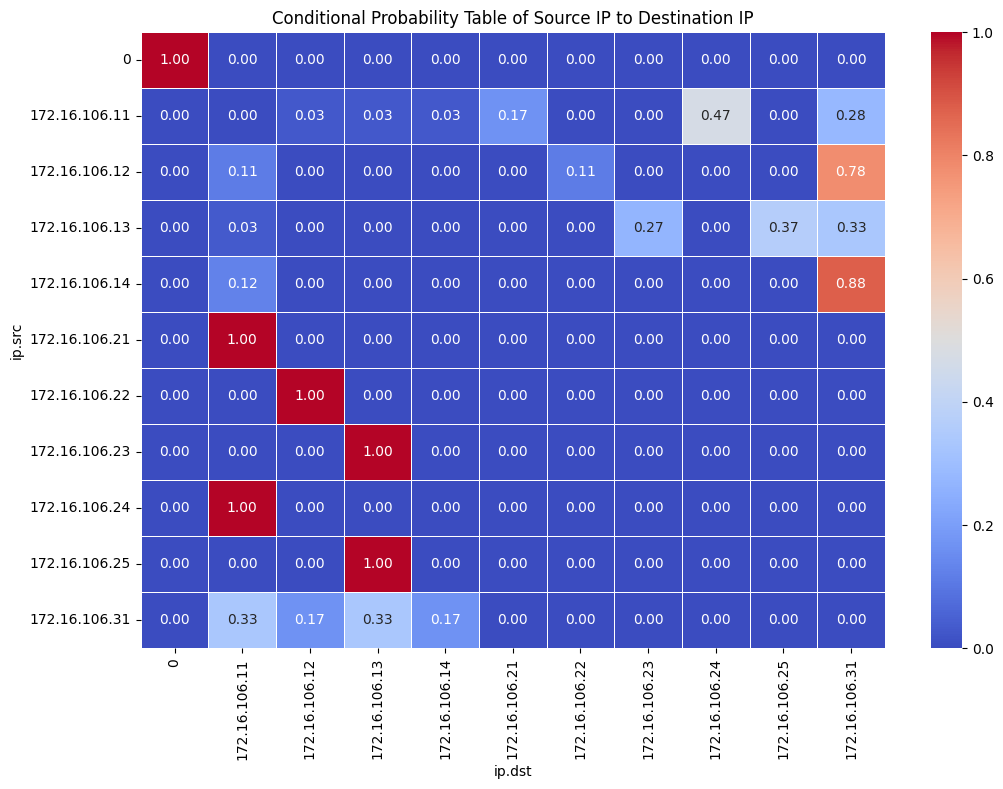

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(association_table_ip_src_to_ip_dst, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("ip.dst")
plt.ylabel("ip.src")
plt.title("Conditional Probability Table of Source IP to Destination IP")

plt.savefig("ip_src_to_ip_dst_cpt_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()

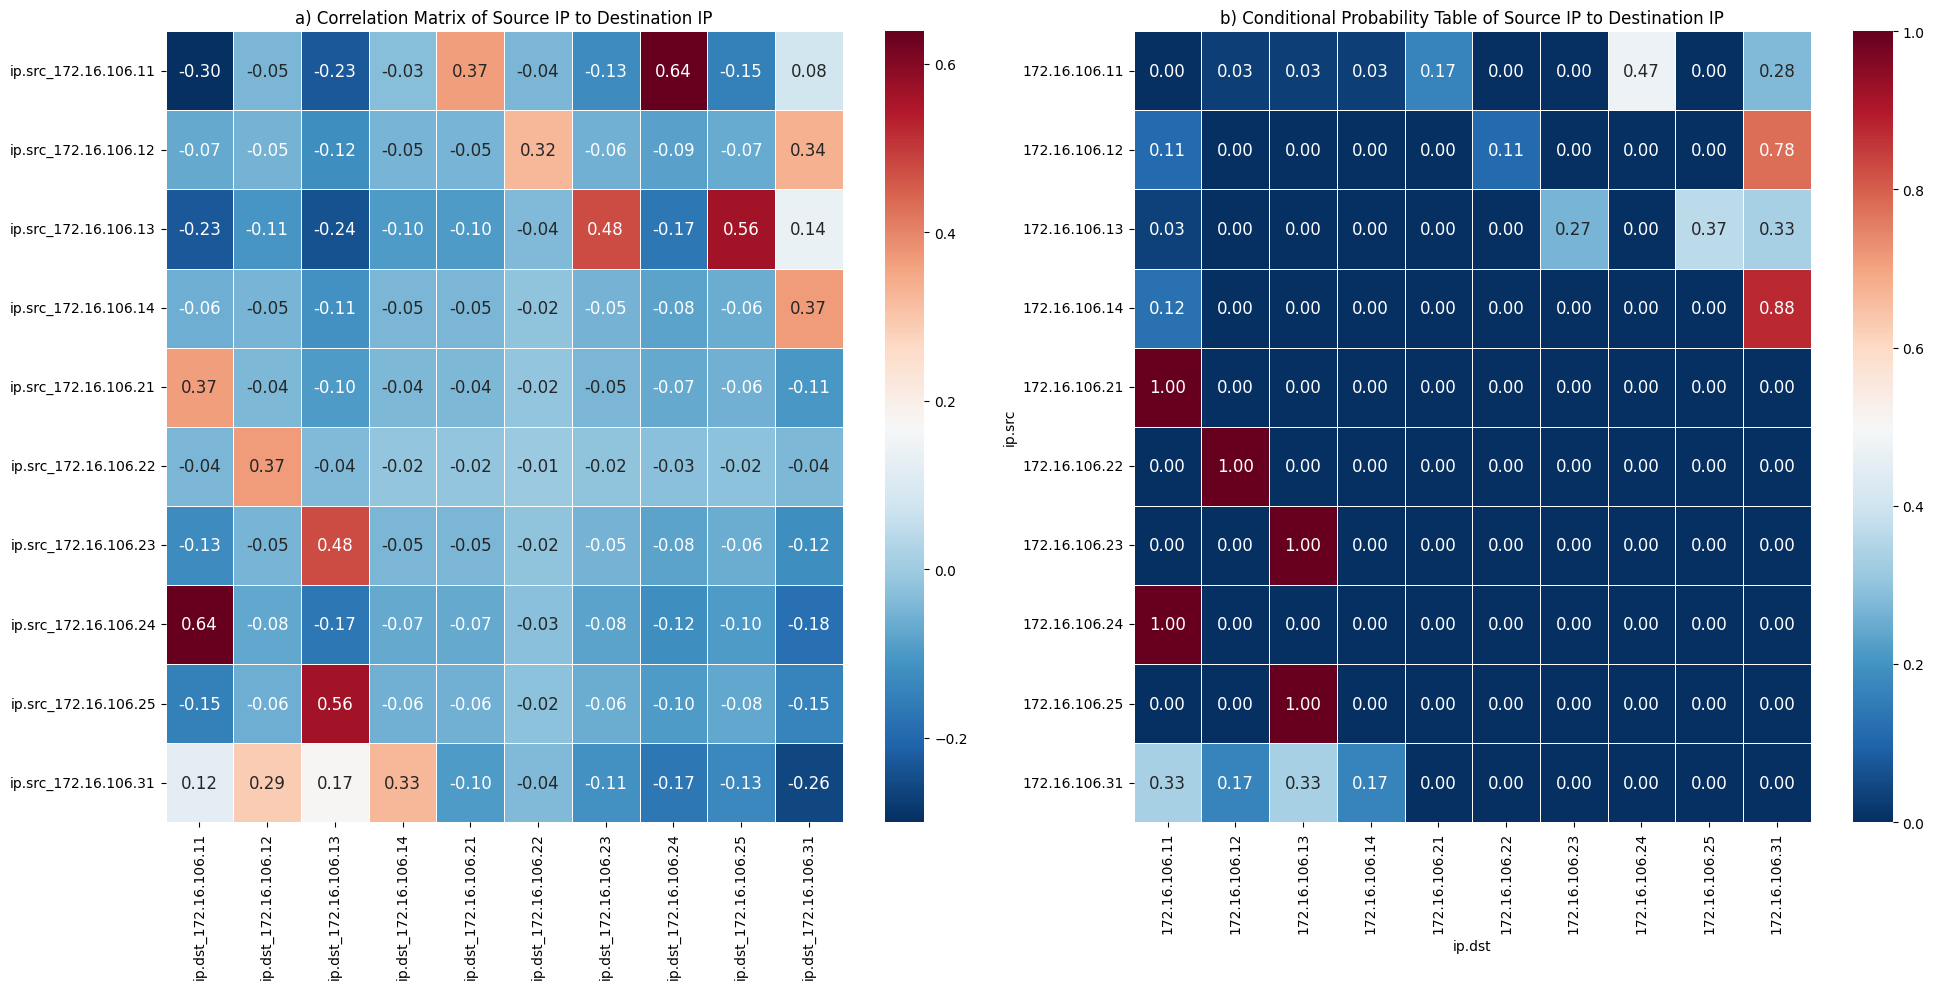

In [47]:
filtered_df_correlation_matrix_ip_src_to_ip_dst = pd.read_csv("filtered_df_correlation_matrix_ip_src_to_ip_dst.csv", index_col=0)
association_table_ip_src_to_ip_dst = pd.read_csv("ip_src_to_ip_dst.csv", index_col=0)

filtered_df_association_table_ip_src_to_ip_dst = association_table_ip_src_to_ip_dst[~association_table_ip_src_to_ip_dst.index.str.startswith("0")]

# Drop columns that start with 'ip.src'
filtered_df_association_table_ip_src_to_ip_dst = filtered_df_association_table_ip_src_to_ip_dst.loc[:, ~filtered_df_association_table_ip_src_to_ip_dst.columns.str.startswith("0")]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the correlation matrix
sns.heatmap(filtered_df_correlation_matrix_ip_src_to_ip_dst, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0.5, ax=axes[0], annot_kws={"size": 12})  
axes[0].set_title("a) Correlation Matrix of Source IP to Destination IP")

# Plot the conditional probability table
sns.heatmap(filtered_df_association_table_ip_src_to_ip_dst, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0.5, ax=axes[1], annot_kws={"size": 12})  
axes[1].set_xlabel("ip.dst")
axes[1].set_ylabel("ip.src")
axes[1].set_title("b) Conditional Probability Table of Source IP to Destination IP")

plt.tight_layout()
plt.savefig("combined_heatmaps_correlation_and_cpt_ip_src_to_ip_dst.pdf", dpi=800, bbox_inches="tight")
plt.show()


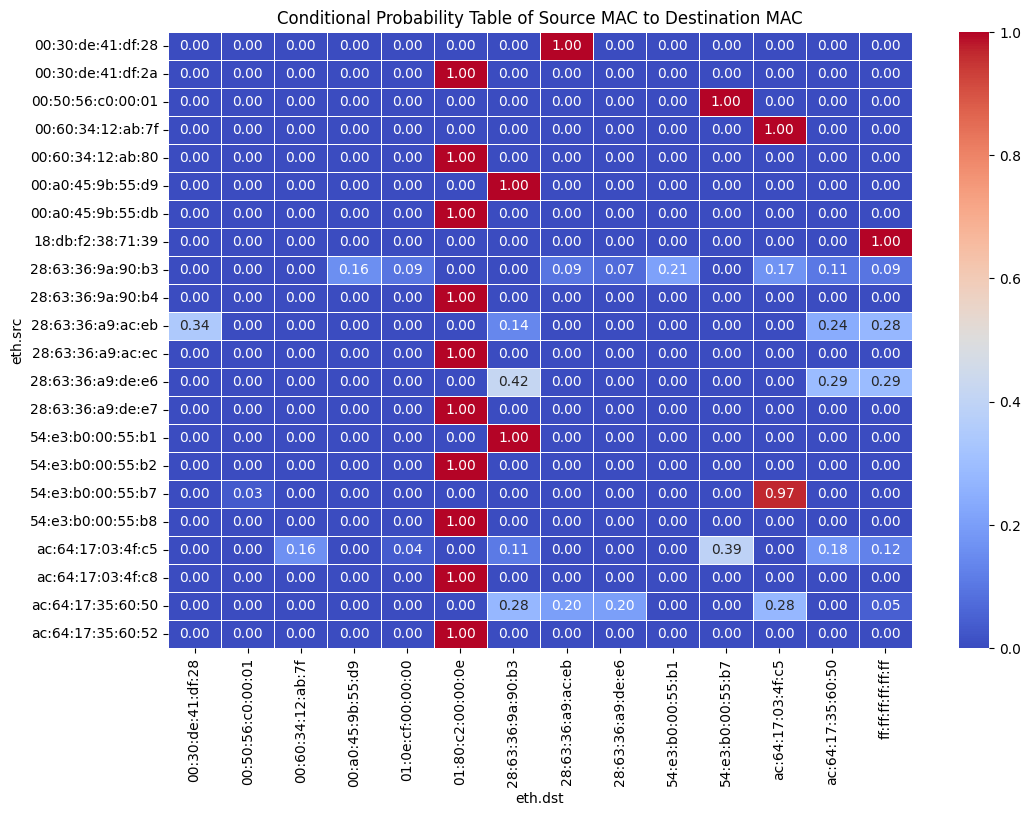

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(association_table_eth_src_to_eth_dst, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("eth.dst")
plt.ylabel("eth.src")
plt.title("Conditional Probability Table of Source MAC to Destination MAC")

plt.savefig("eth_src_to_eth_dst_cpt_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()

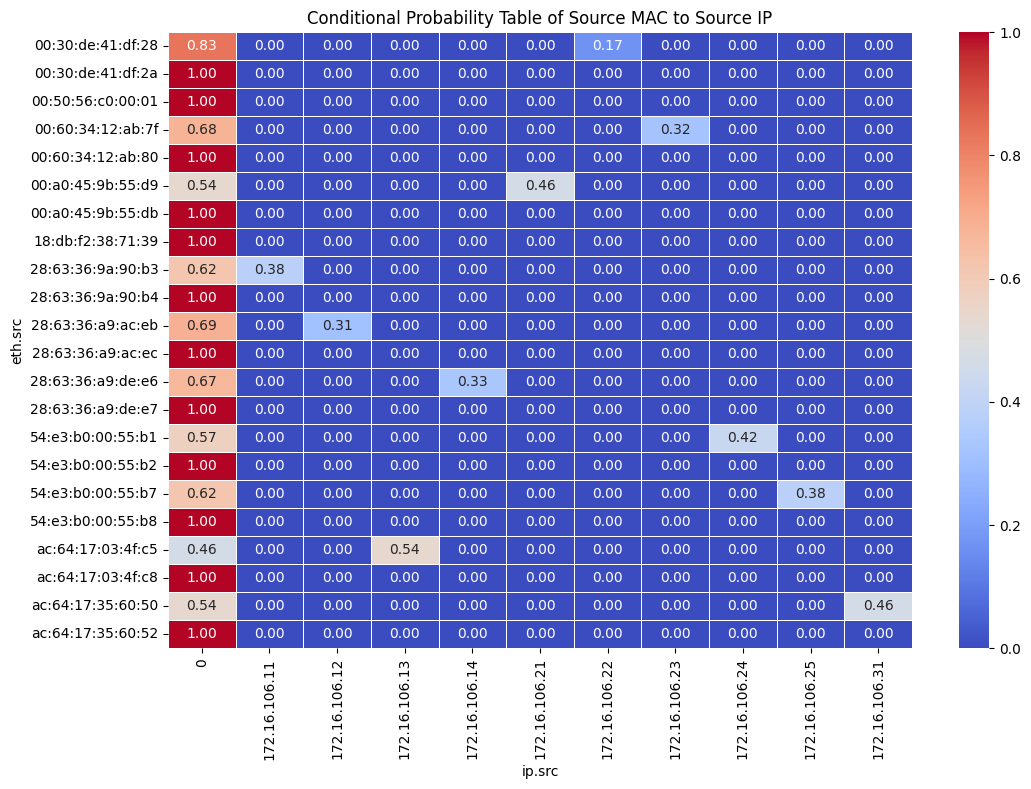

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(association_table_eth_src_to_ip_src, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("ip.src")
plt.ylabel("eth.src")
plt.title("Conditional Probability Table of Source MAC to Source IP")

plt.savefig("eth_src_to_ip_src_cpt_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()

Get Attacker's Details (MAC and IP)

In [50]:
# 172.16.106.199
# 18:db:f2:38:71:39

def is_valid_ip(ip):
    pattern = r"^(?:\d{1,3}\.){3}\d{1,3}$"
    return re.match(pattern, ip) is not None and all(0 <= int(octet) <= 255 for octet in ip.split("."))

def is_valid_mac(mac):
    pattern = r"^(?:[0-9a-f]{2}:){5}[0-9a-f]{2}$"  
    return re.match(pattern, mac) is not None

# Keep asking for valid IP
while True:
    attacker_ip = input("Enter the attacker's IP address: ").strip()
    if is_valid_ip(attacker_ip):
        break
    print("❌ Invalid IP format! Please enter a valid IP (e.g., 192.168.1.1).")

# Keep asking for valid MAC
while True:
    attacker_mac = input("Enter the attacker's MAC address: ").strip().lower()  
    if is_valid_mac(attacker_mac):
        break
    print("❌ Invalid MAC format! Please enter a valid MAC (e.g., 00:1a:2b:3c:4d:5e).")

print(f"\n✅ Attacker's IP: {attacker_ip}")
print(f"✅ Attacker's MAC: {attacker_mac}")


✅ Attacker's IP: 172.16.106.199
✅ Attacker's MAC: 18:db:f2:38:71:39


In [51]:
dataset_eval = test

# Make a copy as perturbations.csv
dataset_eval.to_csv("perturbations_2.csv", index=False)
print("Created a copy of dataset_eval as perturbations_2.csv")

# Load perturbations.csv for modification
perturbations = pd.read_csv("perturbations_2.csv")

# Load ip_src_to_ip_dst.csv as a probability matrix
ip_matrix = pd.read_csv("ip_src_to_ip_dst.csv", index_col=0)

mac_matrix = pd.read_csv("ip_src_to_eth_src.csv", index_col=0)

# Find rows where attacker_ip appears in either ip.src or ip.dst
attacker_rows_src = perturbations[perturbations["ip.src"] == attacker_ip]
attacker_rows_dst = perturbations[perturbations["ip.dst"] == attacker_ip]

# Find rows where attacker_mac appears in either eth.src or eth.dst
attacker_rows_mac_src = perturbations[perturbations["eth.src"] == attacker_mac]
attacker_rows_mac_dst = perturbations[perturbations["eth.dst"] == attacker_mac]

# ---- PERTURB ATTACKER'S IP ----
# Process each row where the attacker's IP is in ip.src
for index, row in attacker_rows_src.iterrows():
    ip_dst_value = row["ip.dst"]  # Get corresponding ip.dst

    # Check if ip_dst_value exists in the probability matrix
    if ip_dst_value in ip_matrix.index:
        # Get probabilities for the destination row (excluding attacker_ip)
        prob_row = ip_matrix.loc[ip_dst_value].drop(attacker_ip, errors='ignore')

        if not prob_row.empty:
            # Select the IP with the highest probability
            new_ip = prob_row.idxmax()

            # Replace attacker's IP in ip.src
            perturbations.at[index, "ip.src"] = new_ip
            print(f"Replaced {attacker_ip} in ip.src with {new_ip} for ip.dst {ip_dst_value}")

# Process each row where the attacker's IP is in ip.dst
for index, row in attacker_rows_dst.iterrows():
    ip_src_value = row["ip.src"]  # Get corresponding ip.src

    # Check if ip_src_value exists in the probability matrix
    if ip_src_value in ip_matrix.index:
        # Get probabilities for the source row (excluding attacker_ip)
        prob_col = ip_matrix.loc[ip_src_value].drop(attacker_ip, errors='ignore')

        if not prob_col.empty:
            # Select the IP with the highest probability
            new_ip = prob_col.idxmax()

            # Replace attacker's IP in ip.dst
            perturbations.at[index, "ip.dst"] = new_ip
            print(f"Replaced {attacker_ip} in ip.dst with {new_ip} for ip.src {ip_src_value}")

# ---- PERTURB ATTACKER'S MAC ----
# Replace eth.src based on new ip.src
for index, row in attacker_rows_mac_src.iterrows():
    new_ip_src = perturbations.at[index, "ip.src"]  # Get updated ip.src

    if new_ip_src in mac_matrix.index:
        prob_row = mac_matrix.loc[new_ip_src].drop(attacker_mac, errors='ignore')
        prob_row = prob_row[prob_row > 0]  

        if not prob_row.empty:
            new_mac = prob_row.idxmax()

            # Replace attacker's MAC in eth.src
            perturbations.at[index, "eth.src"] = new_mac
            print(f"Replaced {attacker_mac} in eth.src with {new_mac} for new ip.src {new_ip_src}")

# Replace eth.dst based on new ip.dst
for index, row in attacker_rows_mac_dst.iterrows():
    new_ip_dst = perturbations.at[index, "ip.dst"]  # Get updated ip.dst

    if new_ip_dst in mac_matrix.index:
        prob_col = mac_matrix.loc[new_ip_dst].drop(attacker_mac, errors='ignore')
        prob_col = prob_col[prob_col > 0]  

        if not prob_col.empty:
            new_mac = prob_col.idxmax()

            # Replace attacker's MAC in eth.dst
            perturbations.at[index, "eth.dst"] = new_mac
            print(f"Replaced {attacker_mac} in eth.dst with {new_mac} for new ip.dst {new_ip_dst}")

# Save the updated perturbations.csv
perturbations.to_csv("perturbations_2.csv", index=False)
print("Perturbations updated and saved as perturbations_2.csv")

Created a copy of dataset_eval as perturbations_2.csv
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.14
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.14
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.14
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.14
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.14
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.14
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.12
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.12
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.12
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.12
Replaced 172.16.106.199 in ip.src with 172.16.106.31 for ip.dst 172.16.106.12
Replaced 172.16.106.199 in ip.dst with 172.16.106.31 for ip.src 172.16.106.14
Replaced 1

Evaluation of Adversarial Perturbations on the selected Surrogate Model

In [52]:
combined_perturbation = pd.concat([train, perturbations], keys=['train', 'test'], ignore_index=False)

X_combined_perturbation = combined_perturbation.drop(['Predictions', 'ground_truth', 'frame.number'], axis=1).fillna(0).astype(str)

X_combined_encoded_perturbation = pd.get_dummies(X_combined_perturbation, drop_first=True).fillna(0)

train_rows_perturbation = combined_perturbation.index.get_level_values(0) == 'train'
X_test_encoded_perturbation = X_combined_encoded_perturbation[~train_rows_perturbation]

In [53]:
y_adv_pred = selected_model.predict(X_test_encoded_perturbation)

In [54]:
if selected_model_name == "Model_5":
    accuracy = accuracy_gt_5
    precision = precision_gt_5
    recall = recall_gt_5
    conf_matrix = conf_matrix_gt_5
elif selected_model_name == "Model_4":
    accuracy = accuracy_gt_4
    precision = precision_gt_4
    recall = recall_gt_4
    conf_matrix = conf_matrix_gt_4
elif selected_model_name == "Model_3":
    accuracy = accuracy_gt_3
    precision = precision_gt_3
    recall = recall_gt_3
    conf_matrix = conf_matrix_gt_3
elif selected_model_name == "Model_2":
    accuracy = accuracy_gt_2
    precision = precision_gt_2
    recall = recall_gt_2
    conf_matrix = conf_matrix_gt_2
elif selected_model_name == "Model_1":
    accuracy = accuracy_gt_1
    precision = precision_gt_1
    recall = recall_gt_1
    conf_matrix = conf_matrix_gt_1

Surrogate Model Performance on Clean Data
Clean Accuracy: 0.8699
Clean Precision: 0.5556
Clean Recall: 0.8696
Attack Success Rate: 0.1304

Surrogate Model Performance on Adversarial Data
Robust Accuracy: 0.7877
Robust Precision: 0.3182
Robust Recall: 0.3043
Adversarial Attack Success Rate: 0.6957


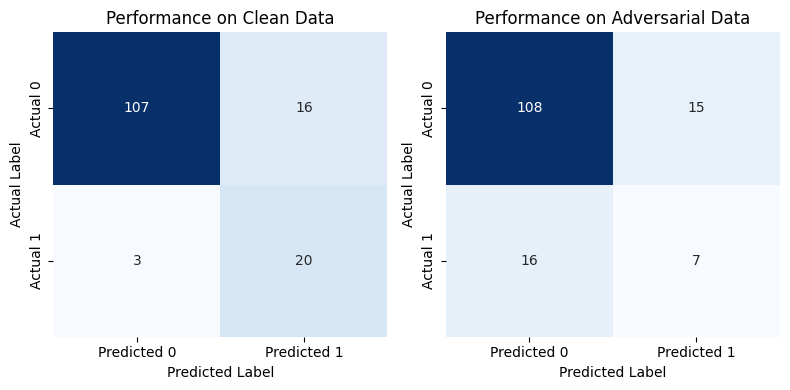

In [55]:
y_adv_pred = list(map(int, y_adv_pred))
y_gt_test = list(map(int, y_test_gt))

# Calculate Robust accuracy, precision, and recall wrt Ground Truth
accuracy_gt_adv = accuracy_score(y_gt_test, y_adv_pred)
precision_gt_adv = precision_score(y_gt_test, y_adv_pred)
recall_gt_adv = recall_score(y_gt_test, y_adv_pred)
conf_matrix_gt_adv = confusion_matrix(y_gt_test, y_adv_pred)

asr = 1 - recall

# Calculate Attack Success Rate (ASR)
adv_asr = 1 - recall_gt_adv

print("Surrogate Model Performance on Clean Data")
print(f"Clean Accuracy: {accuracy:.4f}")
print(f"Clean Precision: {precision:.4f}")
print(f"Clean Recall: {recall:.4f}")
print(f"Attack Success Rate: {asr:.4f}\n")


print("Surrogate Model Performance on Adversarial Data")
print(f"Robust Accuracy: {accuracy_gt_adv:.4f}")
print(f"Robust Precision: {precision_gt_adv:.4f}")
print(f"Robust Recall: {recall_gt_adv:.4f}")
print(f"Adversarial Attack Success Rate: {adv_asr:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Performance on Clean Data')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(conf_matrix_gt_adv, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Performance on Adversarial Data')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('surrogate_model_performance_confusion_matrix_2.pdf', format='pdf', dpi=800)
plt.show()

In [118]:
# To check which rows didn't change their prediction after spoofing
# Reason - The surrogate model is making predicitions based on some other feature (eg: function) and not the ip and mac for these rows.

# import numpy as np

# # Convert to NumPy arrays
# y_gt_test = np.atleast_1d(np.array(y_gt_test))
# y1_pred = np.atleast_1d(np.array(y1_pred))
# y_adv_pred = np.atleast_1d(np.array(y_adv_pred))

# # Find indices
# indices = np.where((y_gt_test == 1) & (y1_pred != y_adv_pred))[0]
# print(indices)

Refinement of Perturbations

In [56]:
dataset_eval.to_csv("refined_perturbations.csv", index=False)
print("Created a copy of dataset_eval as refined_perturbations.csv")

refined_perturbations = pd.read_csv("refined_perturbations.csv")
ip_matrix = pd.read_csv("ip_src_to_ip_dst.csv", index_col=0)
mac_matrix = pd.read_csv("ip_src_to_eth_src.csv", index_col=0)

asr_refined = asr
recall_gt_adv_refined = recall_gt_adv

asr_threshold = 0.70  # Adjust as needed

def compute_asr(x):
    return 1 - x

def refine_perturbations():
    global refined_perturbations  

    # Find attacker_ip related rows
    attacker_rows_src = refined_perturbations[refined_perturbations["ip.src"] == attacker_ip]
    attacker_rows_dst = refined_perturbations[refined_perturbations["ip.dst"] == attacker_ip]

    # Find rows where attacker_mac appears in either eth.src or eth.dst
    attacker_rows_mac_src = refined_perturbations[refined_perturbations["eth.src"] == attacker_mac]
    attacker_rows_mac_dst = refined_perturbations[refined_perturbations["eth.dst"] == attacker_mac]

    refined = False  # Track if any changes were made

    # ---- PERTURB ATTACKER'S IP ----
    # Process each row where the attacker's IP is in ip.src

    for i, (index, row) in enumerate(attacker_rows_src.iterrows(), start=1):
        ip_dst_value = row["ip.dst"]  # Get corresponding ip.dst

        # Check if ip_dst_value exists in the probability matrix
        if ip_dst_value in ip_matrix.index:
            # Get probabilities for the destination row (excluding attacker_ip)
            prob_row = ip_matrix.loc[ip_dst_value].drop(attacker_ip, errors='ignore')
            prob_row = prob_row.sort_values(ascending=False)  # Sort by highest probability

            if len(prob_row) > 1:  # Ensure there's a next high probability
                if i >= len(prob_row):
                    break
                new_ip = prob_row.index[i]  # Pick the next highest probability
                refined_perturbations.at[index, "ip.src"] = new_ip
                refined = True

                # Replace attacker's IP in ip.src
                refined_perturbations.at[index, "ip.src"] = new_ip
                # print(f"Replaced {attacker_ip} in ip.src with {new_ip} for ip.dst {ip_dst_value}")

    # Process each row where the attacker's IP is in ip.dst
    for i, (index, row) in enumerate(attacker_rows_dst.iterrows(), start=1):
        ip_src_value = row["ip.src"]  # Get corresponding ip.src

        # Check if ip_src_value exists in the probability matrix
        if ip_src_value in ip_matrix.index:
            # Get probabilities for the source row (excluding attacker_ip)
            prob_col = ip_matrix.loc[ip_src_value].drop(attacker_ip, errors='ignore')
            prob_col = prob_col.sort_values(ascending=False)
            # print(prob_col)
            
            if len(prob_col) > 1:
                if i >= len(prob_col):
                    break
                new_ip = prob_col.index[i]
                refined_perturbations.at[index, "ip.dst"] = new_ip
                refined = True

                # Replace attacker's IP in ip.dst
                refined_perturbations.at[index, "ip.dst"] = new_ip
                # print(f"Replaced {attacker_ip} in ip.dst with {new_ip} for ip.src {ip_src_value}")

    # ---- PERTURB ATTACKER'S MAC ----
    # Replace eth.src based on new ip.src
    for index, row in attacker_rows_mac_src.iterrows():
        new_ip_src = refined_perturbations.at[index, "ip.src"]  # Get updated ip.src

        if new_ip_src in mac_matrix.index:
            prob_row = mac_matrix.loc[new_ip_src].drop(attacker_mac, errors='ignore')
            prob_row = prob_row[prob_row > 0]  

            if not prob_row.empty:
                new_mac = prob_row.idxmax()

                # Replace attacker's MAC in eth.src
                refined_perturbations.at[index, "eth.src"] = new_mac
                # print(f"Replaced {attacker_mac} in eth.src with {new_mac} for new ip.src {new_ip_src}")

    # Replace eth.dst based on new ip.dst
    for index, row in attacker_rows_mac_dst.iterrows():
        new_ip_dst = refined_perturbations.at[index, "ip.dst"]  # Get updated ip.dst

        if new_ip_dst in mac_matrix.index:
            prob_col = mac_matrix.loc[new_ip_dst].drop(attacker_mac, errors='ignore')
            prob_col = prob_col[prob_col > 0]  

            if not prob_col.empty:
                new_mac = prob_col.idxmax()

                # Replace attacker's MAC in eth.dst
                refined_perturbations.at[index, "eth.dst"] = new_mac
                # print(f"Replaced {attacker_mac} in eth.dst with {new_mac} for new ip.dst {new_ip_dst}")

    return refined  # Return if any changes were made


# Iteratively refine perturbations until ASR meets/exceeds the threshold
while True:

    if asr_refined >= asr_threshold:
        print("ASR meets/exceeds the threshold. Stopping refinement.")
        break

    refined = refine_perturbations()

    combined_refined_perturbation = pd.concat([train, refined_perturbations], keys=['train', 'test'], ignore_index=False)

    X_combined_refined_perturbation = combined_refined_perturbation.drop(['Predictions', 'ground_truth', 'frame.number'], axis=1).fillna(0).astype(str)

    X_combined_encoded_refined_perturbation = pd.get_dummies(X_combined_refined_perturbation, drop_first=True).fillna(0)

    train_rows_refined_perturbation = combined_refined_perturbation.index.get_level_values(0) == 'train'
    X_test_encoded_refined_perturbation = X_combined_encoded_refined_perturbation[~train_rows_refined_perturbation]

    y_adv_refined_pred = selected_model.predict(X_test_encoded_refined_perturbation)

    y_adv_refined_pred = list(map(int, y_adv_refined_pred))

    recall_gt_adv_refined = recall_score(y_gt_test, y_adv_refined_pred)

    asr_current = compute_asr(recall_gt_adv_refined)
    print(f"Current ASR: {asr_current}")

    if asr_current <= asr_refined:
        break
    
    if not refined:
        print("No further valid perturbations possible. Stopping refinement.")
        break

# Save refined perturbations
refined_perturbations.to_csv("refined_perturbations.csv", index=False)
print("Refined perturbations saved as refined_perturbations.csv")

Created a copy of dataset_eval as refined_perturbations.csv
Current ASR: 0.6086956521739131
Current ASR: 0.6521739130434783
Current ASR: 0.6521739130434783
No further valid perturbations possible. Stopping refinement.
Refined perturbations saved as refined_perturbations.csv


Create Adversarial Network Packets (adv.pcap)

In [57]:
dataset_csv = "dataset_eval.csv"
perturbations_csv = "perturbations_2.csv"
# perturbations_csv = "refined_perturbations.csv"
input_pcap = "eval.pcap"
# output_pcap = "refined_perturbations.pcap"
output_pcap = "perturbations.pcap"

# Step 1: Extract Packet Numbers
df_dataset = pd.read_csv(dataset_csv)
target_mac = "18:db:f2:38:71:39"

# Find packet numbers where eth.src or eth.dst matches the target MAC
packet_numbers = df_dataset[
    (df_dataset["eth.src"] == target_mac) | (df_dataset["eth.dst"] == target_mac)
].index.tolist()  # Indices are the packet numbers in eval.pcap - Indexing using index() starts after the column names

# Step 2: Load Perturbations
df_perturbations = pd.read_csv(perturbations_csv)

# Step 3: Read and Modify PCAP
packets = rdpcap(input_pcap)  # Load packets using Scapy

for pkt_num in packet_numbers:
    if pkt_num >= len(packets):  # Ensure packet exists
        continue
    
    pkt = packets[pkt_num]  # Scapy is 0 based index and csv is also 0 based index

    # Replace Ethernet addresses
    pkt[Ether].src = df_perturbations.loc[pkt_num, "eth.src"]
    pkt[Ether].dst = df_perturbations.loc[pkt_num, "eth.dst"]

    # Replace IP addresses if IP layer is present
    if IP in pkt:
        pkt[IP].src = df_perturbations.loc[pkt_num, "ip.src"]
        pkt[IP].dst = df_perturbations.loc[pkt_num, "ip.dst"]

        # Recalculate the checksum
        pkt[IP].chksum = None 
        
        if TCP in pkt:
            pkt[TCP].chksum = None

# Step 4: Save Modified PCAP
wrpcap(output_pcap, packets)

print(f"Modified PCAP saved as {output_pcap}")

Modified PCAP saved as perturbations.pcap


Evaluation of Evasion Attack on Targeted NIDS model

In [58]:
### Append NIDS predictions after the evasion attack to perturbations.csv in 'Predictions_2' column and upload the file below

perturbations_df = pd.read_csv('perturbations.csv')
eval_df = pd.read_csv('dataset_eval.csv')

NIDS Performance before Adversarial Attack
Clean Accuracy: 0.8973
Clean Precision: 0.6176
Clean Recall: 0.9130
Attack Success Rate: 0.0870

NIDS Performance after Adversarial Attack
Robust Accuracy: 0.8219
Robust Precision: 0.4348
Robust Recall: 0.4348
Adversarial Attack Success Rate: 0.5652


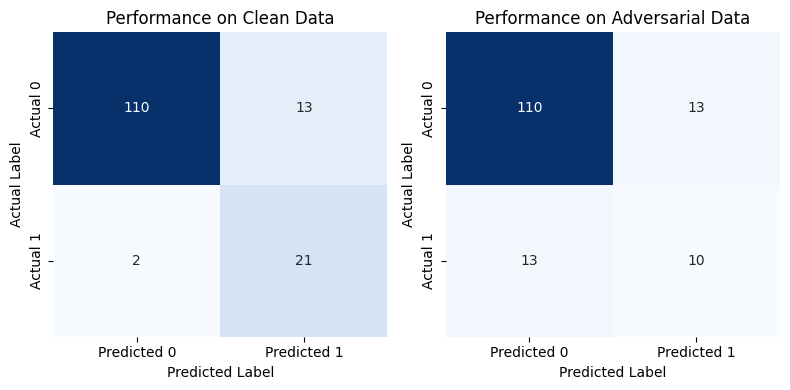

In [59]:
y_eval_pred = perturbations_df['Predictions_2'].astype(str)
y_eval_gt = perturbations_df['ground_truth'].astype(str)

y_pred_eval_clean = eval_df['Predictions_2'].astype(str)

y_eval_pred = list(map(int, y_eval_pred))
y_eval_gt = list(map(int, y_eval_gt))

y_pred_eval_clean = list(map(int, y_pred_eval_clean))

nids_eval_clean_accuracy = accuracy_score(y_eval_gt, y_pred_eval_clean)
nids_eval_clean_precision = precision_score(y_eval_gt, y_pred_eval_clean)
nids_eval_clean_recall = recall_score(y_eval_gt, y_pred_eval_clean)
nids_eval_clean_conf_matrix = confusion_matrix(y_eval_gt, y_pred_eval_clean)

nids_clean_asr = 1 - nids_eval_clean_recall


nids_robust_accuracy = accuracy_score(y_eval_gt, y_eval_pred)
nids_robust_precision = precision_score(y_eval_gt, y_eval_pred)
nids_robust_recall = recall_score(y_eval_gt, y_eval_pred)
nids_robust_conf_matrix = confusion_matrix(y_eval_gt, y_eval_pred)

nids_adv_asr = 1 - nids_robust_recall

print("NIDS Performance before Adversarial Attack")
print(f"Clean Accuracy: {nids_eval_clean_accuracy:.4f}")
print(f"Clean Precision: {nids_eval_clean_precision:.4f}")
print(f"Clean Recall: {nids_eval_clean_recall:.4f}")
print(f"Attack Success Rate: {nids_clean_asr:.4f}\n")

print("NIDS Performance after Adversarial Attack")
print(f"Robust Accuracy: {nids_robust_accuracy:.4f}")
print(f"Robust Precision: {nids_robust_precision:.4f}")
print(f"Robust Recall: {nids_robust_recall:.4f}")
print(f"Adversarial Attack Success Rate: {nids_adv_asr:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# nids_clean_conf_matrix
sns.heatmap(nids_eval_clean_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[0])
axes[0].set_title('Performance on Clean Data')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')
# nids_robust_conf_matrix
sns.heatmap(nids_robust_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=axes[1])
axes[1].set_title('Performance on Adversarial Data')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('robust_performance_nids_confusion_matrix.pdf', format='pdf', dpi=800)
plt.show()


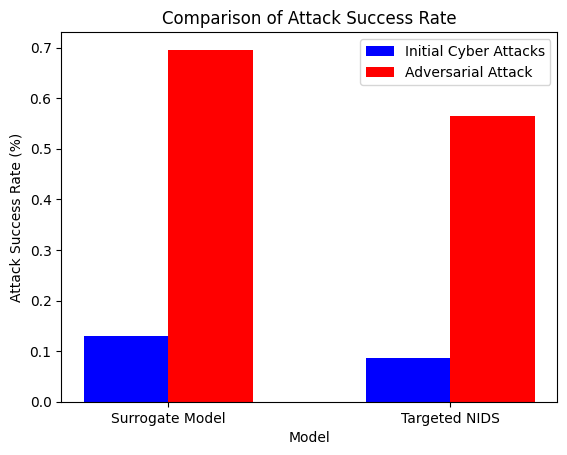

In [60]:

models = ["Surrogate Model", "Targeted NIDS"]
initial_values = [asr, nids_clean_asr]
refined_values = [adv_asr, nids_adv_asr]

x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, initial_values, width, label='Initial Cyber Attacks', color='blue')
bars2 = ax.bar(x + width/2, refined_values, width, label='Adversarial Attack', color='red')

ax.set_xlabel("Model")
ax.set_ylabel("Attack Success Rate (%)")
ax.set_title("Comparison of Attack Success Rate")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        # ax.annotate(f'{height}%', 
        #             xy=(bar.get_x() + bar.get_width() / 2, height),
        #             xytext=(0, 3),
        #             textcoords="offset points",
        #             ha='center', va='bottom')
plt.savefig('attack_success_rate_plot.pdf', format='pdf', dpi=800)
plt.show()

In [61]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

Total execution time: 143.10 seconds
